# Random Forest Regression

### Import Data & Libraries

In [90]:
import pandas as pd
import numpy as np    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score  

In [91]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables) 


{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [92]:
y = y.squeeze()

In [93]:
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [94]:
X['Sex'] = pd.factorize(X['Sex'])[0]

/var/folders/zc/3ypsxm8x317fnxmqtz6btpj00000gn/T/ipykernel_12961/1253931446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = pd.factorize(X['Sex'])[0]


In [95]:
mask = X["Sex"] != 2
X = X[mask]
y = y[mask]

### Train/Test Split

In [96]:
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test

In [97]:
X_train, X_test, y_train, y_test = split_data(X, y)

### Hyperparameter Tuning

In [98]:
def tune_rfr_model(X_train, y_train):

  # Define the parameter grid
  param_distributions = {'n_estimators': [50, 100, 200, 500],
  'max_depth': [None, 10, 20, 30],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'bootstrap': [True, False]}

  # Instantiate the model
  model = RandomForestRegressor()

  random_search = RandomizedSearchCV(estimator=model,
                                  param_distributions=param_distributions,
                                  n_iter=10,
                                  scoring='neg_mean_squared_error',
                                  cv=5,  # Number of cross-validation folds
                                  verbose=2,  # Show process logs
                                  random_state=42,
                                  n_jobs=-1)

  # Fit random search model
  random_search.fit(X_train, y_train)


  # Best model and hyperparameters
  best_model = random_search.best_estimator_
  best_params = random_search.best_params_

  return best_model, best_params

In [99]:
best_model, best_params = tune_rfr_model(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0

In [100]:
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}


In [101]:
print("Best Model:", best_model)

Best Model: RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=200)


### Model

In [102]:
def RFR_model(X, y, num_replicates=30, test_size=0.2):
    """
    Function to replicate the RFR model,
    perform hyperparameter tuning, and record results.

    Parameters:
    X: Features dataset
    y: Target variable
    num_replicates: Number of replicates to run the experiment
    test_size: Proportion of the dataset to include in the test split

    Returns:
    rmse_list: List of RMSE values from each replicate
    r2_list: List of R² values from each replicate
    best_predictions: Predictions from the best model based on smallest RMSE
    best_model_params: Hyperparameters of the best model based on smallest RMSE
    """
    rmse_list = []
    r2_list = []
    best_rmse = float('inf')
    y_train = None
    best_predictions = None
    best_model_params = None

    for i in range(num_replicates):
        # Train-test split
        X_train, X_test, y_train, y_test = split_data(X, y,
                                                            test_size=test_size,
                                                            random_state=i)

        #  Standardize the data (RF does not require normalization)
        #X_train_scaled, X_test_scaled= normalize_data(X_train, X_test)

        # Hyperparameter tuning
        best_model, best_params = tune_rfr_model(X_train, y_train)

        # Predict on the test set
        y_pred = best_model.predict(X_test)

        # Calculate RMSE and R²
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Record RMSE and R²
        rmse_list.append(rmse)
        r2_list.append(r2)

        # Update the best model based on the smallest RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_predictions = y_pred
            y_test= y_test
            best_model_params = best_params

    return rmse_list, r2_list, best_predictions, y_test, best_model_params

In [103]:
rmse_list, r2_list, best_predictions,y_train, best_model_params = RFR_model(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0

### Model Evaluation

In [104]:
num_replicates = 30

In [105]:
print(f'RMSE from {num_replicates} replicates {rmse_list}')
print(f'R2 from {num_replicates} replicates {r2_list}')

RMSE from 30 replicates [np.float64(2.4469837719531373), np.float64(2.3044337885717034), np.float64(2.245320964806768), np.float64(2.4179263487417773), np.float64(2.466559509929239), np.float64(2.1353090054266928), np.float64(2.4264950032152086), np.float64(2.507239653137314), np.float64(2.212537071819752), np.float64(2.3526683728860656), np.float64(2.3542973355876975), np.float64(2.4268882869619963), np.float64(2.244877517525166), np.float64(2.204800899075028), np.float64(2.2590033006237635), np.float64(2.3773526982389313), np.float64(2.205064153085946), np.float64(2.4107940154559278), np.float64(2.39051653258762), np.float64(2.4045710077580686), np.float64(2.5616725081305396), np.float64(2.353262688686303), np.float64(2.2010458123204324), np.float64(2.3090729444310623), np.float64(2.309852863405123), np.float64(2.3003545836996224), np.float64(2.314728548588481), np.float64(2.348126500185635), np.float64(2.2089333689422643), np.float64(2.177719338890232)]
R2 from 30 replicates [0.4325

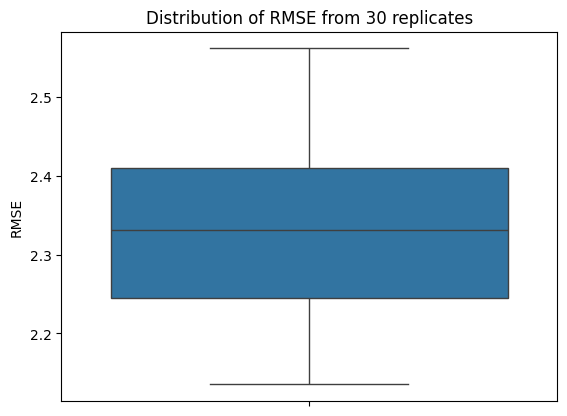

In [106]:
# Create the boxplot
sns.boxplot(data=rmse_list)

# Adding labels and title
plt.title('Distribution of RMSE from 30 replicates')
plt.ylabel('RMSE')

# Show the plot
plt.show()

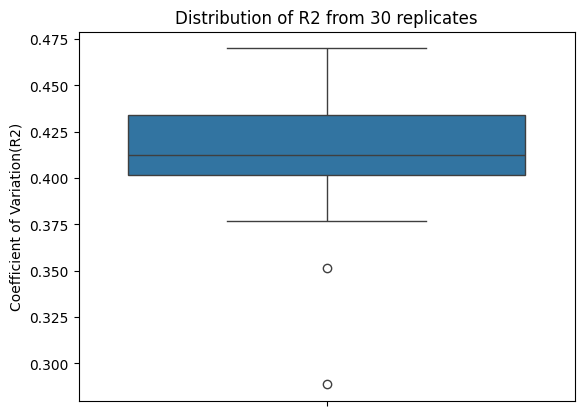

In [107]:
# Create the boxplot
sns.boxplot(data=r2_list)

# Adding labels and title
plt.title('Distribution of R2 from 30 replicates')
plt.ylabel('Coefficient of Variation(R2)')

# Show the plot
plt.show()

In [108]:
def plot_true_vs_pred(y_true, y_pred):
    # Make both 1-D numeric arrays
    y_true = np.asarray(y_true).squeeze()
    y_pred = np.asarray(y_pred).squeeze()

    # Drop NaN/inf pairs just in case
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', label='Predicted vs Actual')

    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi], linestyle='--', label='Perfect Prediction')

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

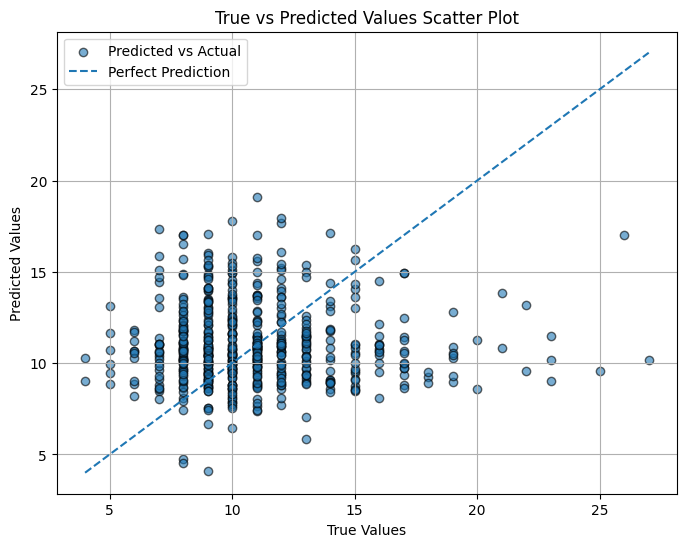

In [109]:
plot_true_vs_pred(y_test, best_predictions)